In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [3]:
results = pd.read_csv("../test_results/pg_duck_tpch_test_results.csv") 
test_name = "postgres_duck_db"

results = results.rename(columns={"Average": "Mean"})

In [4]:
print(len(results))
results.head()

88


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,6.370,True,Yes,"[6.4829206466674805, 6.112210273742676, 6.0885..."
1,SQL,1,Duck DB,Query 1,0.426,True,Yes,"[0.4917769432067871, 0.42227673530578613, 0.41..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,2.430,True,Yes,"[7.15959906578064, 1.510803461074829, 1.478646..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,1.910,True,Yes,"[2.4505927562713623, 1.823503017425537, 1.7725..."
4,SQL,1,Postgres,Query 2,1.180,True,Yes,"[1.2991671562194824, 1.2142317295074463, 1.162..."


In [5]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

88


In [6]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_mean(runs):
    return g_mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [7]:
def make_compare_graph(df, order, color, filename):
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x='Query Number', y='Mean', hue='Query Type',
                     palette=color, hue_order=order)

    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    plt.savefig(filename, bbox_inches="tight")
    plt.show()

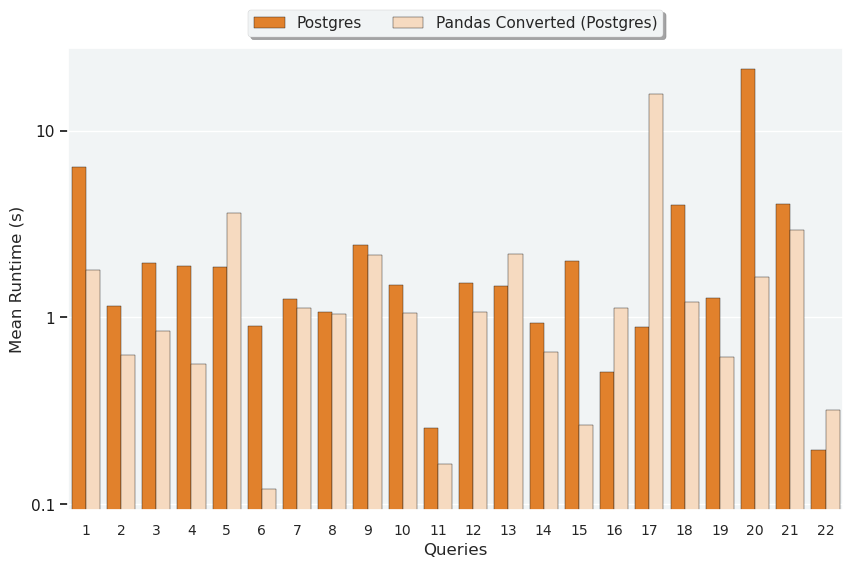

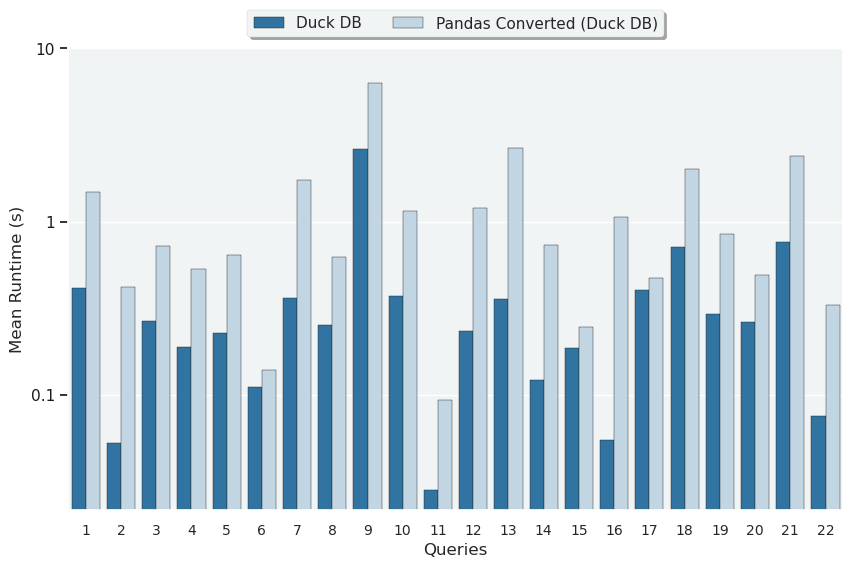

In [8]:
pg_df = results[results["Query Type"].isin(["Postgres", "Pandas Converted (Postgres)"])]
pg_order = ["Postgres", "Pandas Converted (Postgres)"]
pg_color = ['tab:orange','#ffd9b7']
pg_filename = "analysis_results/postgres_compare_queries.pdf"

make_compare_graph(pg_df, pg_order, pg_color, pg_filename)

pg_df = results[results["Query Type"].isin(["Duck DB", "Pandas Converted (Duck DB)"])]
pg_order = ["Duck DB", "Pandas Converted (Duck DB)"]
pg_color = ['tab:blue', '#bcd6e9']
pg_filename = "../analysis_results/duck_db_compare_queries.pdf"

make_compare_graph(pg_df, pg_order, pg_color, pg_filename)

In [19]:
def calculate_cv(A):
    cv =  (np.std(A) / g_mean(A))
    return cv

In [20]:
# Number to show peformance of each, in comparison to each other
group_results = results \
    .groupby(['Query Type'], sort=False) \
    .agg(
        mean_runtime=("Mean", g_mean),
        standard_dev=("Mean", np.std),
        min_runtime=("Mean", np.min),
        max_runtime=("Mean", np.max),
        coeff_var=("Mean", calculate_cv),
    )

#group_results = group_results.sort_values(by=["mean_runtime"])
group_results

,mean_runtime,standard_dev,min_runtime,max_runtime,coeff_var
Query Type,,,,,
Postgres,1.512787,4.388830,0.196000,21.274027,2.834454
Duck DB,0.230512,0.538886,0.028286,2.638528,2.284033
Pandas Converted (Duck DB),0.768219,1.339345,0.093445,6.274831,1.703357
Pandas Converted (Postgres),0.992155,3.211612,0.120351,15.661692,3.162581


### Make a graph for Q9, Q17 and Q20

In [ ]:
specific_queries = results[(results["Query Number"].isin([17,20]))]
#specific_queries.head(20)

In [ ]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

# The other colors are 70% tints of the original
# From: https://imagecolorpicker.com/color-code/
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]
color = ['tab:orange', 'tab:blue', '#ffd9b7', '#bcd6e9']

ax = sns.barplot(data=specific_queries, x='Query Number', y='Mean', hue='Query Type',
                 palette=color, hue_order=order)

ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

# the non-logarithmic labels 
ticks = [0.1, 1, 10]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=4, fancybox=True, shadow=True)

plt.savefig("../analysis_results/postgres_duck_db_specific_queries.pdf", bbox_inches="tight")
plt.show()